In [1]:
import numpy as np
import pandas as pd

frame = pd.read_excel("data_gdm_discrete_BMI_merged.xlsx", engine="openpyxl")
frame.oDM = (frame.oDM == 2).astype(int)
for name in frame.columns:
    frame[name] = frame[name].astype('category')
# ['SmokeCat1', 'SmokeCat2', 'GravCat']
# frame = frame.drop('oDM', axis=1)
print (frame)
print (frame.oDM.value_counts())

     AgeCat BMICat Race Education GravCat SmokeCat1 SmokeCat2 oDM
0         3      0    1         3       2         1         1   0
1         1      2    2         2       1         1         2   0
2         0      0    2         1       1         2         2   0
3         2      2    3         3       2         2         2   0
4         1      0    3         4       1         2         2   0
...     ...    ...  ...       ...     ...       ...       ...  ..
9215      2      1    1         4       2         1         1   0
9216      1      0    3         3       2         2         2   0
9217      0      0    3         1       2         2         2   0
9218      2      1    1         2       3         1         1   0
9219      3      2    1         5       1         1         1   0

[9220 rows x 8 columns]
0    8832
1     388
Name: oDM, dtype: int64


In [2]:
from sklearn.model_selection import StratifiedKFold
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context
import warnings 

train_data = frame.to_numpy()
names = frame.columns.tolist()
categories = names # ['Race', 'oDM']
ptypes = [Categorical if n in categories else Gaussian for n in names]
categorical = [n in categories for n in names]

In [4]:
from spn.algorithms.Inference import log_likelihood

for n in [20, 40, 60, 80, 100]:
    splitter = StratifiedKFold()
    ll = []
    for train_i, test_i in splitter.split(train_data, train_data[:, -1]):
        train = train_data[train_i]
        test = train_data[test_i]
        
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            context = Context(parametric_types = ptypes).add_domains(train)
            net = learn_parametric(train,
                                   ds_context = context,
                                   min_instances_slice = n)
            l = log_likelihood(net, test)
            ll.append(-np.sum(l))

    print ("%6d %8.4f ± %8.4f" % (n, np.mean(ll), np.std(ll)))

    20 -4659.0594 ± 428.5762
    40 -4273.9511 ± 320.7754
    60 -3720.8372 ± 498.2084
    80 -3476.0385 ± 526.1012
   100 -3418.6699 ± 593.4377


/home/saurabh/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


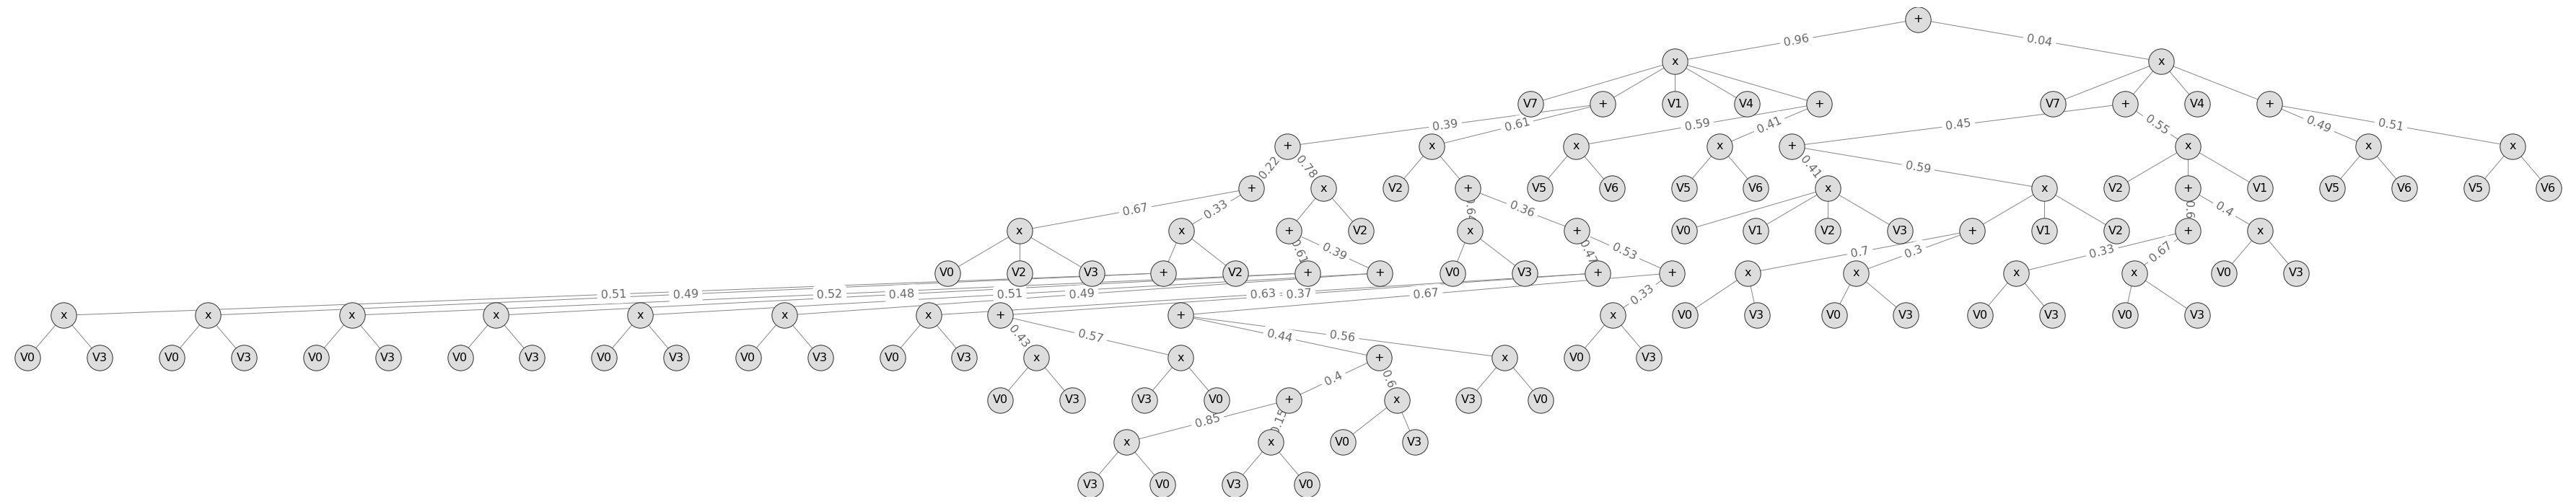

In [3]:
from spn.io.Graphics import plot_spn
import matplotlib.pyplot as plt
%matplotlib inline


context =  Context(parametric_types=ptypes).add_domains(train_data)
net = learn_parametric(train_data, 
                       ds_context = context, 
                       rows = "gmm", 
                       ohe=True, 
                       min_instances_slice = len(train_data) / 100)

plt.figure(figsize=(50, 10))
plot_spn(net)

[Text(170.9,187.033,'BMICat <= 1.5\ngini = 0.5\nsamples = 9220\nvalue = [4610.0, 4610.0]'),
 Text(85.45,112.22,'Race <= 4.5\ngini = 0.484\nsamples = 7192\nvalue = [3642.276, 2542.629]'),
 Text(42.725,37.4067,'gini = 0.47\nsamples = 6518\nvalue = [3313.959, 2007.964]'),
 Text(128.175,37.4067,'gini = 0.471\nsamples = 674\nvalue = [328.316, 534.665]'),
 Text(256.35,112.22,'AgeCat <= 2.5\ngini = 0.434\nsamples = 2028\nvalue = [967.724, 2067.371]'),
 Text(213.625,37.4067,'gini = 0.484\nsamples = 1263\nvalue = [620.095, 891.108]'),
 Text(299.075,37.4067,'gini = 0.352\nsamples = 765\nvalue = [347.629, 1176.263]')]

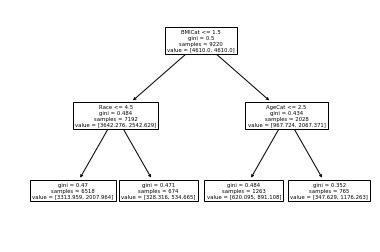

In [14]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

dt = DecisionTreeClassifier(max_depth = 2, class_weight='balanced')
dt.fit(net.X[:, 0:-1], net.y)
plot_tree(dt, feature_names=frame.columns)

In [28]:
from spn.algorithms.splitting.RDC import rdc_test
meta_types = context.get_meta_types_by_scope(net.scope)
domains = context.get_domains_by_scope(net.scope)
rdc_test(net.X, meta_types, domains, k=None, s=1.0/6.0, non_linearity=np.sin) < 0.4

array([[False,  True, False, False,  True,  True,  True,  True],
       [ True, False,  True,  True,  True,  True,  True,  True],
       [False,  True, False, False,  True,  True,  True,  True],
       [False,  True, False, False,  True,  True,  True,  True],
       [ True,  True,  True,  True, False,  True,  True,  True],
       [ True,  True,  True,  True,  True, False, False,  True],
       [ True,  True,  True,  True,  True, False, False,  True],
       [ True,  True,  True,  True,  True,  True,  True, False]])

In [8]:
import numpy as np

np.__version__

'1.19.2'

In [6]:
from csi import annotate, context_specific_independences

annotate(net, names, categorical, min_impurity_decrease=0.1, min_instances_slice = 38 )
for rule in context_specific_independences(net):
    print (rule)

([['oDM == 0']], [['oDM'], ['AgeCat', 'Race', 'Education'], ['BMICat'], ['GravCat'], ['SmokeCat1', 'SmokeCat2']], 1.0, 8832)
([['oDM != 0']], [['oDM'], ['AgeCat', 'BMICat', 'Race', 'Education'], ['GravCat'], ['SmokeCat1', 'SmokeCat2']], 1.0, 388)
([['oDM == 0'], ['Race == 1']], [['Race'], ['AgeCat', 'Education']], 1.0, 5412)
([['oDM == 0'], ['SmokeCat1 == 2']], [['SmokeCat1'], ['SmokeCat2']], 1.0, 5181)
([['oDM == 0'], ['SmokeCat1 != 2']], [['SmokeCat1'], ['SmokeCat2']], 1.0, 3651)
([['oDM != 0'], ['Race == 1']], [['Race'], ['AgeCat', 'Education'], ['BMICat']], 1.0, 214)
([['oDM != 0'], ['SmokeCat1 != 2']], [['SmokeCat1'], ['SmokeCat2']], 1.0, 192)
([['oDM != 0'], ['SmokeCat1 == 2']], [['SmokeCat1'], ['SmokeCat2']], 1.0, 196)
([['oDM == 0'], ['Race != 1'], ['Race != 3 and Race == 2', 'Race == 3']], [['AgeCat', 'Education'], ['Race']], 0.997736703130894, 2651)
([['oDM != 0'], ['Race != 1'], ['Race != 5 and Race == 8', 'Race == 5']], [['AgeCat'], ['BMICat'], ['Race'], ['Education']], 0.7

In [8]:
def format_clause(clause):
    parts = []
    subclauses = clause.split(" and ")
    for subclause in subclauses:
        a, sign, b = subclause.split(" ")
        parts.append("(%s %s %s)" % (a, sign, b))
    return " & ".join(parts)
def format_rule(rule):
    antecedent, consequent, score, support = rule
    
    anodes = [' | '.join(["(%s)"%format_clause(clause) 
                          if len(node) > 1 else format_clause(clause)  
                          for clause in node]) 
              for node in antecedent]
    antecedent = ' & '.join(["(%s)" % node 
                             if len(node) > 1 else "%s" % node
                             for node in anodes])
    cnodes = ["(%s)" % ", ".join(node) for node in consequent]
    consequent = ", ".join(cnodes)
    return antecedent, consequent, round(score, 4), min(support, len(train))
import csi
train = train_data
for rule in csi.context_specific_independences(net):
    rule = format_rule(rule)
    print ("{%s} => {%s} (%.2f, %d)" % rule, end="\n\n")

{((oDM == 0))} => {(oDM), (AgeCat, Race, Education), (BMICat), (GravCat), (SmokeCat1, SmokeCat2)} (1.00, 8832)

{((oDM != 0))} => {(oDM), (AgeCat, BMICat, Race, Education), (GravCat), (SmokeCat1, SmokeCat2)} (1.00, 388)

{((oDM == 0)) & ((Race == 1))} => {(Race), (AgeCat, Education)} (1.00, 5412)

{((oDM == 0)) & ((SmokeCat1 == 2))} => {(SmokeCat1), (SmokeCat2)} (1.00, 5181)

{((oDM == 0)) & ((SmokeCat1 != 2))} => {(SmokeCat1), (SmokeCat2)} (1.00, 3651)

{((oDM != 0)) & ((Race == 1))} => {(Race), (AgeCat, Education), (BMICat)} (1.00, 214)

{((oDM != 0)) & ((SmokeCat1 != 2))} => {(SmokeCat1), (SmokeCat2)} (1.00, 192)

{((oDM != 0)) & ((SmokeCat1 == 2))} => {(SmokeCat1), (SmokeCat2)} (1.00, 196)

{((oDM == 0)) & ((Race != 1)) & (((Race != 3) & (Race == 2)) | ((Race == 3)))} => {(AgeCat, Education), (Race)} (1.00, 2651)

{((oDM != 0)) & ((Race != 1)) & (((Race != 5) & (Race == 8)) | ((Race == 5)))} => {(AgeCat), (BMICat), (Race), (Education)} (0.77, 71)

{((oDM != 0)) & ((Race != 1)) & ((

In [11]:
rows = []
for rule in csi.context_specific_independences(net):
    rule = format_rule(rule)
    t = ("$%s$ \t %s \t %.2f \t %d" % rule)
    t = t.replace("&", "\land").replace("|", "\lor")
    t = t.replace("==", "=").replace("!=", "\\neq")
    t = t.replace("<=", "\leq")
    t = t.replace("-", "\_")
    rows.append (t.split("\t"))
pd.DataFrame(rows, columns = ['Antecedent', 'Consequent', 'Score', 'Support']).to_csv("numom2b_csi.csv", index=False)